In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import rioxarray as rxr
import contextily as cx
import geopandas as gpd
import pandas as pd
from skimage.measure import find_contours
import ee
import sys
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import rasterio as rio
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LightSource
import glob
import wxee as wx
import matplotlib
import pickle
from scipy.signal import medfilt
from scipy.stats import iqr
import os
import glob
import operator
import json
from ast import literal_eval
import seaborn as sns
import wxee as wx
import geedim as gd
import requests
from PIL import Image
import io
from shapely import wkt
from tqdm.auto import tqdm

# path to glacier-snow-cover-mapping/
base_path = r'C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP'

# path to study sites
study_sites_path = r"C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\study-sites"
# determine whether to save output figures
save_figures = True

# path for saving output figures
figures_out_path = os.path.join(base_path, 'figures')

# add path to functions
sys.path.insert(1, os.path.join(base_path, 'functions'))
import pipeline_utils as f

# load dataset dictionary
dataset_dict = json.load(open(os.path.join(base_path,'inputs-outputs', 'datasets_characteristics.json')))

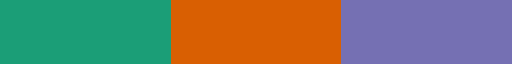

In [2]:
color_Landsat       = '#1b9e77'
color_Sentinel2_SR  = '#d95f02'
color_Sentinel2_TOA = '#7570b3'

ListedColormap([color_Landsat, color_Sentinel2_SR, color_Sentinel2_TOA])

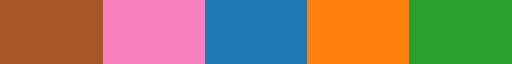

In [3]:
color_scr           = '#a65628'
color_sla_bin       = '#f781bf'
color_sca           = '#1f77b4'  
color_aar           = '#ff7f0e'  
color_snowline      = '#2ca02c'  
ListedColormap([color_scr, color_sla_bin, color_sca, color_aar, color_snowline])

In [4]:
# Define site names
site_names = ['Turner', 'Fountain', 'White', 'Coronation', 'Highway' ,'BylotD20s']

# Load and compile snowlines
sl_ests_full = pd.DataFrame()

for site_name in site_names:
    print(f"Processing site: {site_name}")
    
    # Load estimated snowlines  
    sl_est_path = os.path.join(study_sites_path, site_name)
    sl_est_fns = glob.glob(os.path.join(sl_est_path, '*_snowlines.csv'))
    
    sl_ests = pd.DataFrame()
    for sl_est_fn in sl_est_fns:
        sl_est = pd.read_csv(sl_est_fn)
        
        # Remove extra whitespace from column names
        sl_est.columns = sl_est.columns.str.strip()
        sl_ests = pd.concat([sl_ests, sl_est], ignore_index=True)
    
    if not sl_ests.empty:
        sl_ests['datetime'] = pd.to_datetime(sl_ests['datetime'], errors='coerce')
    
    # Add the site's data to the full DataFrame
    sl_ests_full = pd.concat([sl_ests_full, sl_ests], ignore_index=True)

# Reset index in the full DataFrame
sl_ests_full.reset_index(drop=True, inplace=True)

# Check and add Year and Week columns if datetime conversion was successful
if 'datetime' in sl_ests_full.columns:
    sl_ests_full['Year'] = sl_ests_full['datetime'].dt.year
    try:
        # Try using the new isocalendar() method
        sl_ests_full['Week'] = sl_ests_full['datetime'].dt.isocalendar().week
    except AttributeError:
        # Fallback for older pandas versions
        sl_ests_full['Week'] = sl_ests_full['datetime'].dt.week
else:
    print("No 'datetime' column found in the compiled DataFrame.")

Processing site: Turner
Processing site: Fountain
Processing site: White
Processing site: Coronation
Processing site: Highway
Processing site: BylotD20s


White
BylotD20s
Fountain
Highway
Turner


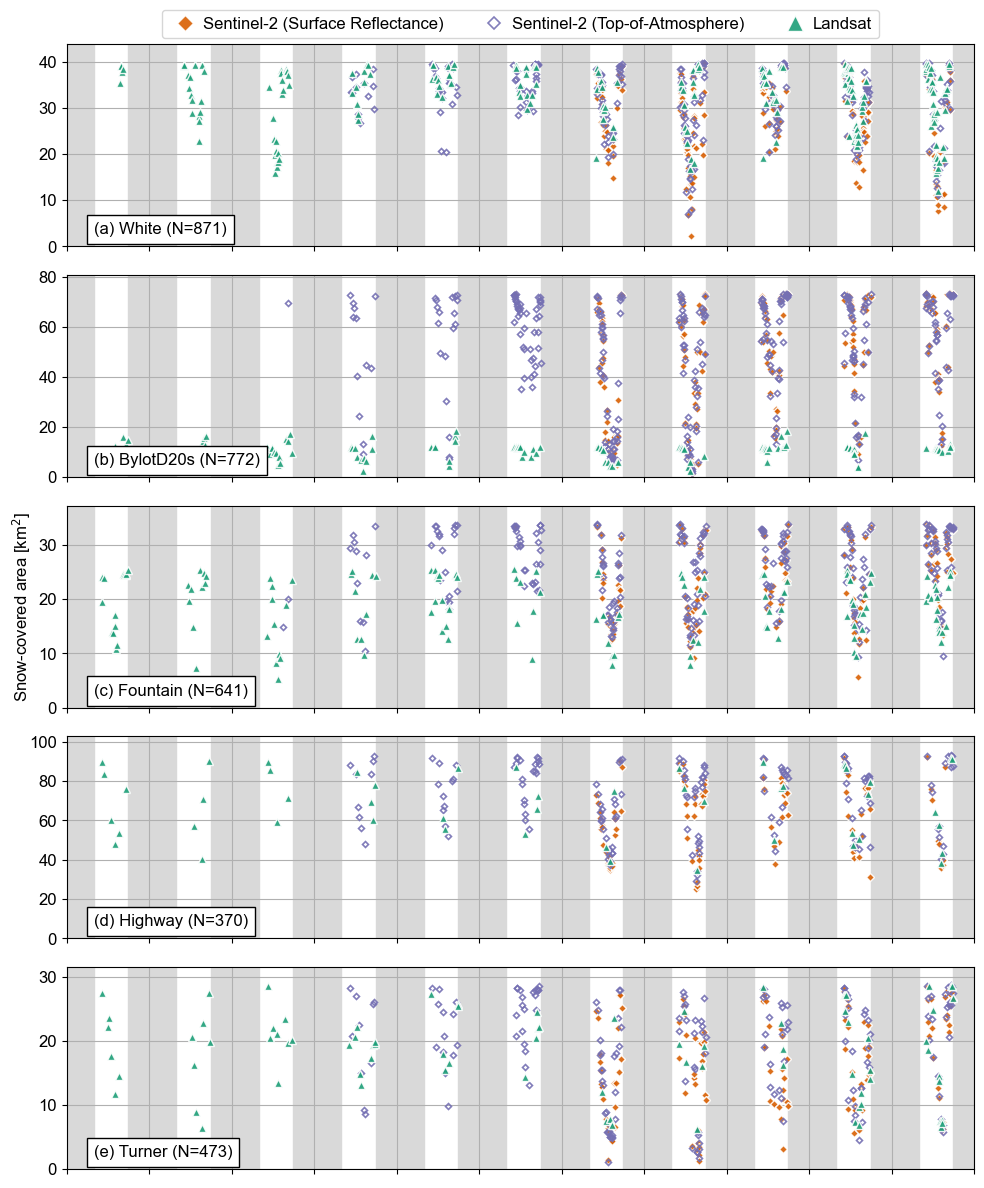

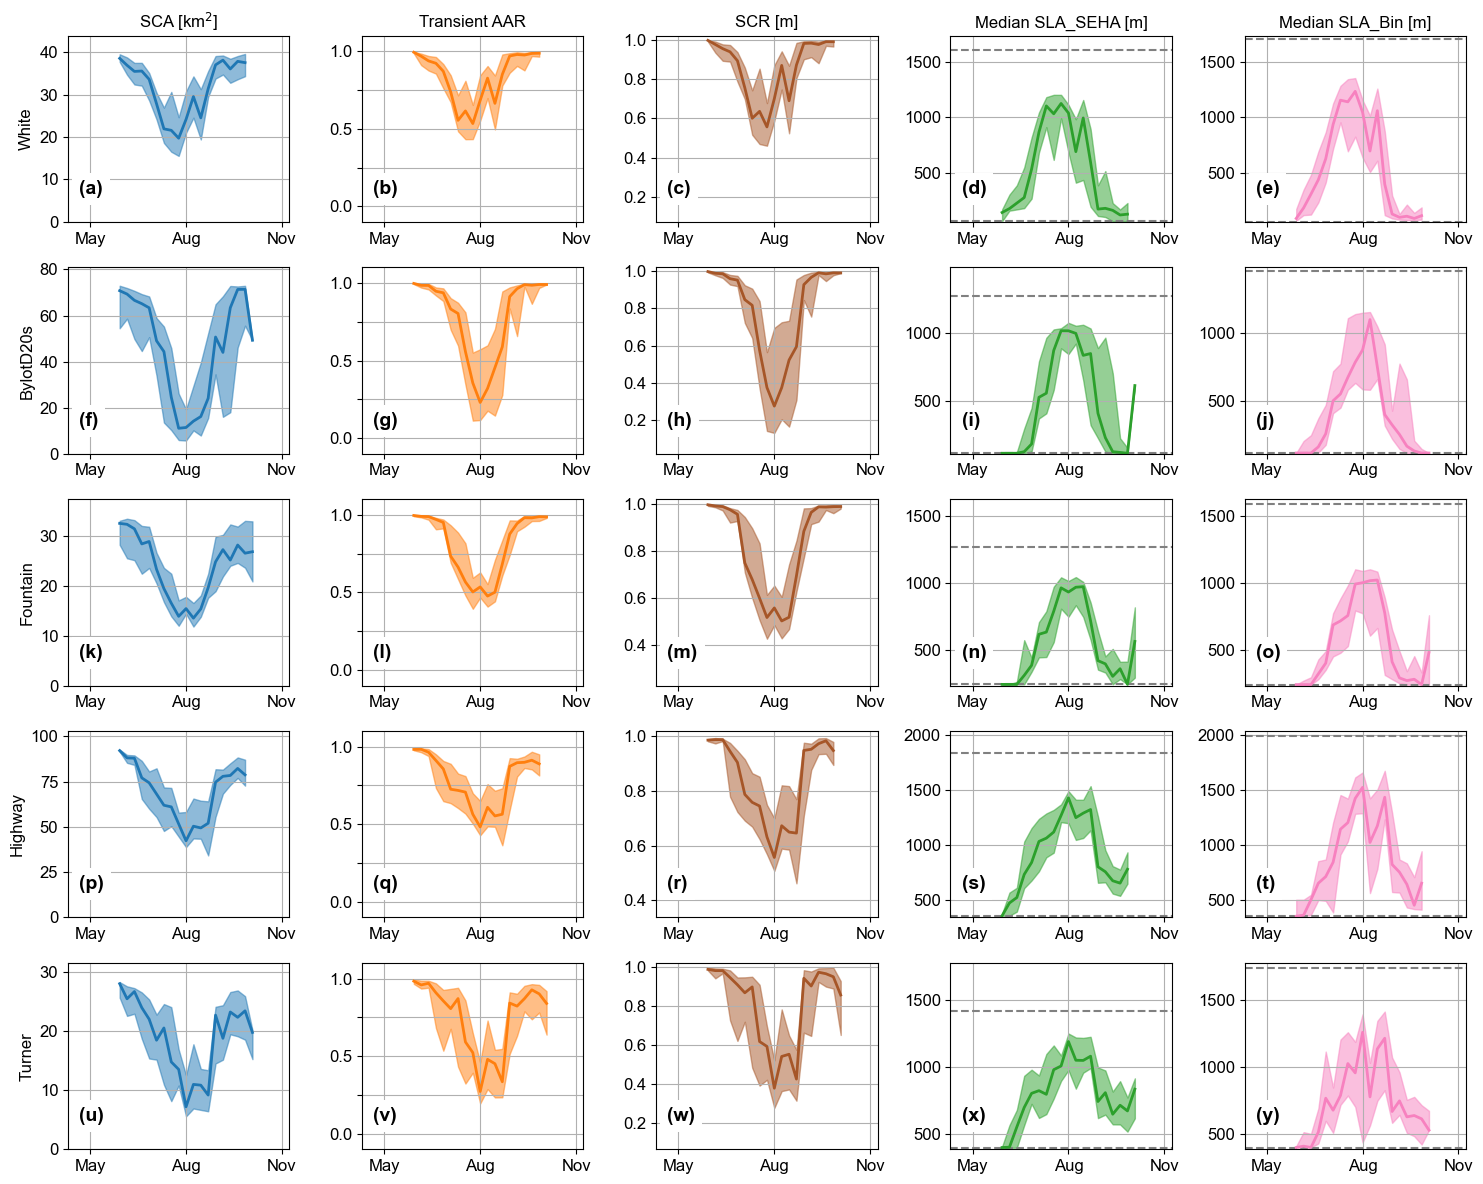

Figure 1 saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\figures\figS3_timeseries_SCA.png
Figure 2 saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\figures\fig05_weekly_median_trends_arranged.png


In [5]:
# -----Settings and display parameters
site_names = ['White', 'BylotD20s', 'Fountain', 'Highway', 'Turner', 'Coronation']
site_names_display = [x.replace('C', ' C') for x in site_names]
text_labels1 = ['(a)', '(b)', '(c)', '(d)', '(e)']

# -----Set up figures
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
# Fig1: Time series (SCA)
fig1, ax1 = plt.subplots(5, 1, figsize=(10, 12))
# Fig2: Weekly median trends with five panels (columns):
#  Column 0: SCA, Column 1: AAR, Column 2: SCR, Column 3: Median snowline, Column 4: SLA (Binned)
fig2, ax2 = plt.subplots(5, 5, figsize=(15, 12))
alpha = 0.9


# Update text labels for Fig2 (5 labels per row)
text_labels2 = [
    ['(a)', '(b)', '(c)', '(d)', '(e)'],
    ['(f)', '(g)', '(h)', '(i)', '(j)'],
    ['(k)', '(l)', '(m)', '(n)', '(o)'],
    ['(p)', '(q)', '(r)', '(s)', '(t)'],
    ['(u)', '(v)', '(w)', '(x)', '(y)']
]

# -----Loop through sites
for site_name, site_name_display, text_label, i in zip(site_names, site_names_display, text_labels1, range(len(site_names))):
    
    print(site_name)
    
    # Subset and sort data for the current site
    sl_ests = sl_ests_full.loc[sl_ests_full['site_name'] == site_name].reset_index(drop=True)
    sl_ests = sl_ests.sort_values(by='datetime')
        
    # -----Define axis limits and y ranges
    xmin, xmax = np.datetime64('2013-05-01T00:00:00'), np.datetime64('2023-12-01T00:00:00')
    yrange1 = [0, np.nanmax(sl_ests['SCA_m2']) * 1e-6 * 1.1]
    yrange2_sca = yrange1
    yrange2_aar = [-0.1, 1.1]
    
    # For SCR
    min_scr = np.nanmin(sl_ests['SCR'])
    max_scr = np.nanmax(sl_ests['SCR'])
    yrange2_scr = [min_scr * 0.97, max_scr * 1.02]
    
    # For Median snowline altitude and SLA (Binned): 
    # Compute a common y-axis range based on both variables.
    sl_elev_median_min = np.nanmin(sl_ests['snowline_elevs_median_m'])
    sl_elev_median_max = np.nanmax(sl_ests['snowline_elevs_median_m'])
    min_sla_bin = np.nanmin(sl_ests['SLA_bin_method_m'])
    max_sla_bin = np.nanmax(sl_ests['SLA_bin_method_m'])
    common_y_min = min(sl_elev_median_min, min_sla_bin) * 0.97
    common_y_max = max(sl_elev_median_max, max_sla_bin) * 1.02
    yrange_common = [common_y_min, common_y_max]
    yrange2_snowline = yrange_common
    yrange2_sla_bin = yrange_common

    # -----Plot light grey boxes where no observations exist on SCA plots
    years = np.arange(2012, 2025, step=1)
    for year in years:
        min_date = np.datetime64(f'{year}-10-01')
        max_date = np.datetime64(f'{year+1}-05-01')
        rect = matplotlib.patches.Rectangle((min_date, yrange1[0]),
                                            width=max_date - min_date,
                                            height=yrange1[1]-yrange1[0],
                                            color='#d9d9d9')
        ax1[i].add_patch(rect)
        
    # -----Plot SCA time series 
    # Sentinel-2 (Surface Reflectance)
    ax1[i].plot(
        sl_ests['datetime'].loc[sl_ests['dataset'] == 'Sentinel-2_SR'], 
        np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset'] == 'Sentinel-2_SR'].values, 1e6),
        'D', markeredgecolor='w', markerfacecolor=color_Sentinel2_SR, 
        alpha=alpha, markersize=4, markeredgewidth=1,
        label='Sentinel-2 (Surface Reflectance)'
    )
    # Sentinel-2 (Top-of-Atmosphere)
    ax1[i].plot(
        sl_ests['datetime'].loc[sl_ests['dataset'] == 'Sentinel-2_TOA'], 
        np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset'] == 'Sentinel-2_TOA'].values, 1e6),
        'D', markeredgecolor=color_Sentinel2_TOA, markerfacecolor='None', 
        alpha=alpha, markersize=3, markeredgewidth=1.2,
        label='Sentinel-2 (Top-of-Atmosphere)'
    )  
    # Landsat
    ax1[i].plot(
        sl_ests['datetime'].loc[sl_ests['dataset'] == 'Landsat'], 
        np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset'] == 'Landsat'].values, 1e6),
        '^', markeredgecolor='w', markerfacecolor=color_Landsat, 
        alpha=alpha, markersize=6, markeredgewidth=1,
        label='Landsat'
    )       

    # -----Add glacier outline and horizontal reference lines:
    ax2[i,3].plot([15, 45], [sl_elev_median_min, sl_elev_median_min], '--', color='grey')
    ax2[i,3].plot([15, 45], [sl_elev_median_max, sl_elev_median_max], '--', color='grey')
    # For SLA (Binned): add horizontal lines for min and max
    ax2[i,4].plot([15, 45], [min_sla_bin, min_sla_bin], '--', color='grey')
    ax2[i,4].plot([15, 45], [max_sla_bin, max_sla_bin], '--', color='grey')
    
    # -----Adjust axes for Fig1
    ax1[i].set_xlim(xmin, xmax)
    ax1[i].set_ylim(yrange1[0], yrange1[1])
    ax1[i].set_xticks([np.datetime64(f'{year}-01-01') for year in np.arange(2013, 2025)])
    if site_name == site_names[-1]:
        ax1[i].set_xticklabels([str(year) for year in np.arange(2013, 2025)])
    else:
        ax1[i].set_xticklabels([])
    ax1[i].grid(True)
    ax1[i].text(np.datetime64('2013-05-01'),
                (ax1[i].get_ylim()[1] - ax1[i].get_ylim()[0]) * 0.06 + ax1[i].get_ylim()[0],
                f"{text_label} {site_name_display} (N={len(sl_ests)})",
                bbox=dict(facecolor='white', edgecolor='black', pad=5))
    if i == 2:
        ax1[i].set_ylabel('Snow-covered area [km$^2$]', fontsize=fontsize)
    ax2[i,0].set_ylabel(site_name_display, fontsize=fontsize)
        
    q1, q3 = 0.25, 0.75
    for ax, column, color, yrange, ylabel in zip(
        [ax2[i,0], ax2[i,1], ax2[i,2], ax2[i,3], ax2[i,4]],
        ['SCA_m2', 'AAR', 'SCR', 'snowline_elevs_median_m', 'SLA_bin_method_m'],
        [color_sca, color_aar, color_scr, color_snowline, color_sla_bin],
        [yrange2_sca, yrange2_aar, yrange2_scr, yrange2_snowline, yrange2_sla_bin],
        ['SCA [km$^2$]', 'Transient AAR', 'SCR [m]', 'Median SLA_SEHA [m]', 'Median SLA_Bin [m]']
    ):
        weekly = sl_ests.groupby(by='Week')[column].agg([
            'median', lambda x: x.quantile(q1), lambda x: x.quantile(q3)
        ])
        weekly.columns = ['Median', 'Q1', 'Q3']
        weekly.index = weekly.index.astype(float)
        if column == 'SCA_m2':
            weekly = weekly / 1e6  # Convert from m^2 to km^2 for SCA
        ax.fill_between(weekly.index, weekly['Q1'], weekly['Q3'], color=color, alpha=0.5)
        ax.plot(weekly.index, weekly['Median'], color=color, linewidth=2)
        ax.grid(True)
        ax.set_xlim(15, 45)
        ax.set_xticks([18, 31, 44])
        ax.set_xticklabels([])
        ax.set_xticklabels(['May', 'Aug', 'Nov'])
        ax.set_ylim(yrange[0], yrange[1])
        if column == 'AAR':
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
            ax.set_yticklabels(['0.0', '', '0.5', '', '1.0'])
        if i == 0:
            ax.set_title(ylabel, fontsize=fontsize)
    
    # -----Add text labels to each subplot in Fig2
    for j in range(5):
        ax2[i, j].text(
            (ax2[i, j].get_xlim()[1] - ax2[i, j].get_xlim()[0]) * 0.05 + ax2[i, j].get_xlim()[0],
            (ax2[i, j].get_ylim()[1] - ax2[i, j].get_ylim()[0]) * 0.15 + ax2[i, j].get_ylim()[0],
            text_labels2[i][j], fontweight='bold', fontsize=fontsize+2,
            bbox=dict(facecolor='white', edgecolor='None', pad=5)
        )

# -----Add legend to Fig1
ax1[0].legend(loc='center', bbox_to_anchor=(0.5, 1.1), handletextpad=0.1,
              labelspacing=0.5, markerscale=2, ncol=4)

fig1.tight_layout()
fig2.tight_layout()
plt.show()

# -----Save figures if desired
if save_figures:
    fig1_fn = os.path.join(figures_out_path, 'figS3_timeseries_SCA.png')
    fig1.savefig(fig1_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('Figure 1 saved to file: ' + fig1_fn)
    fig2_fn = os.path.join(figures_out_path, 'fig05_weekly_median_trends_arranged.png')
    fig2.savefig(fig2_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('Figure 2 saved to file: ' + fig2_fn)

White
BylotD20s
Fountain
Highway
Turner
Coronation


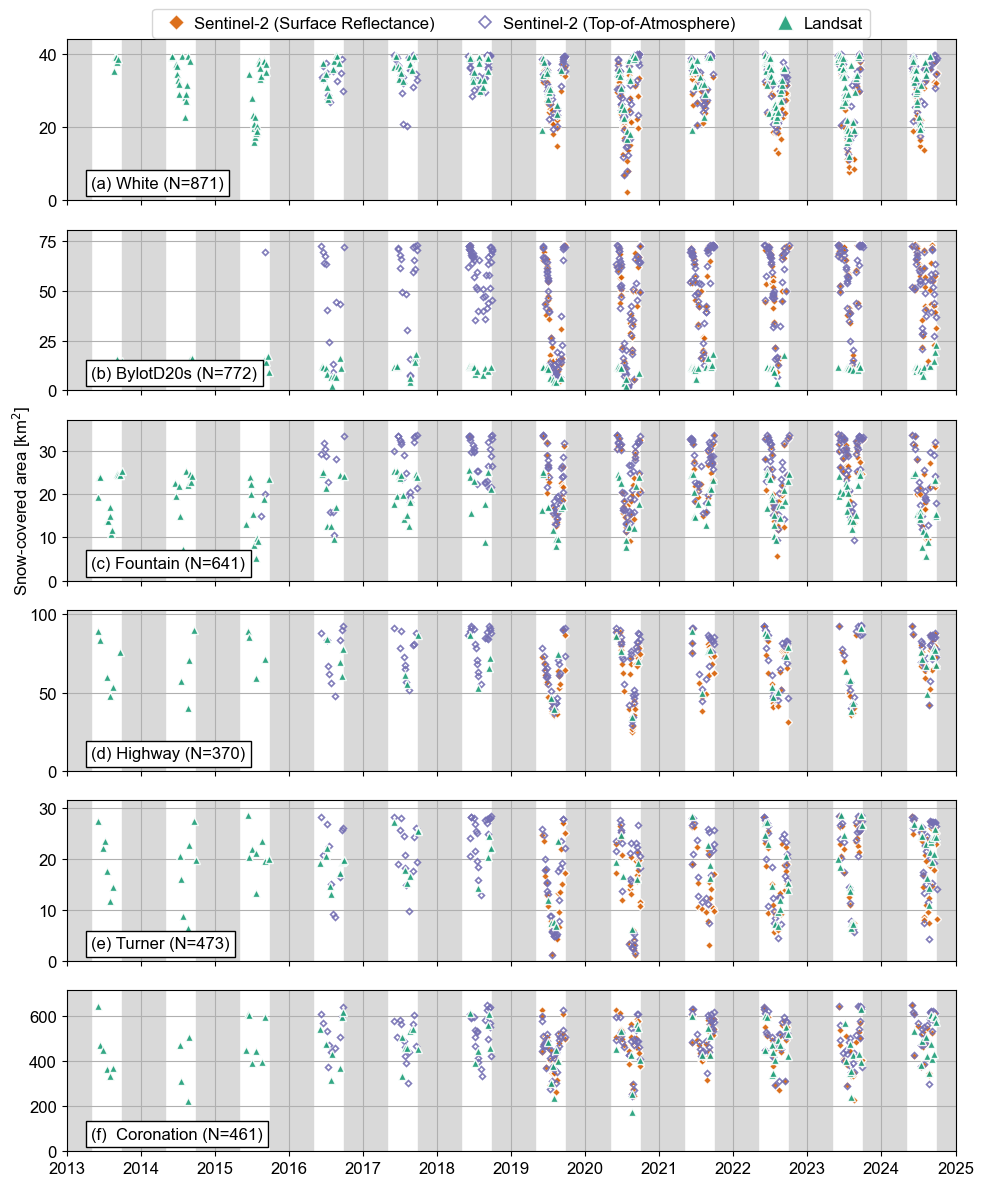

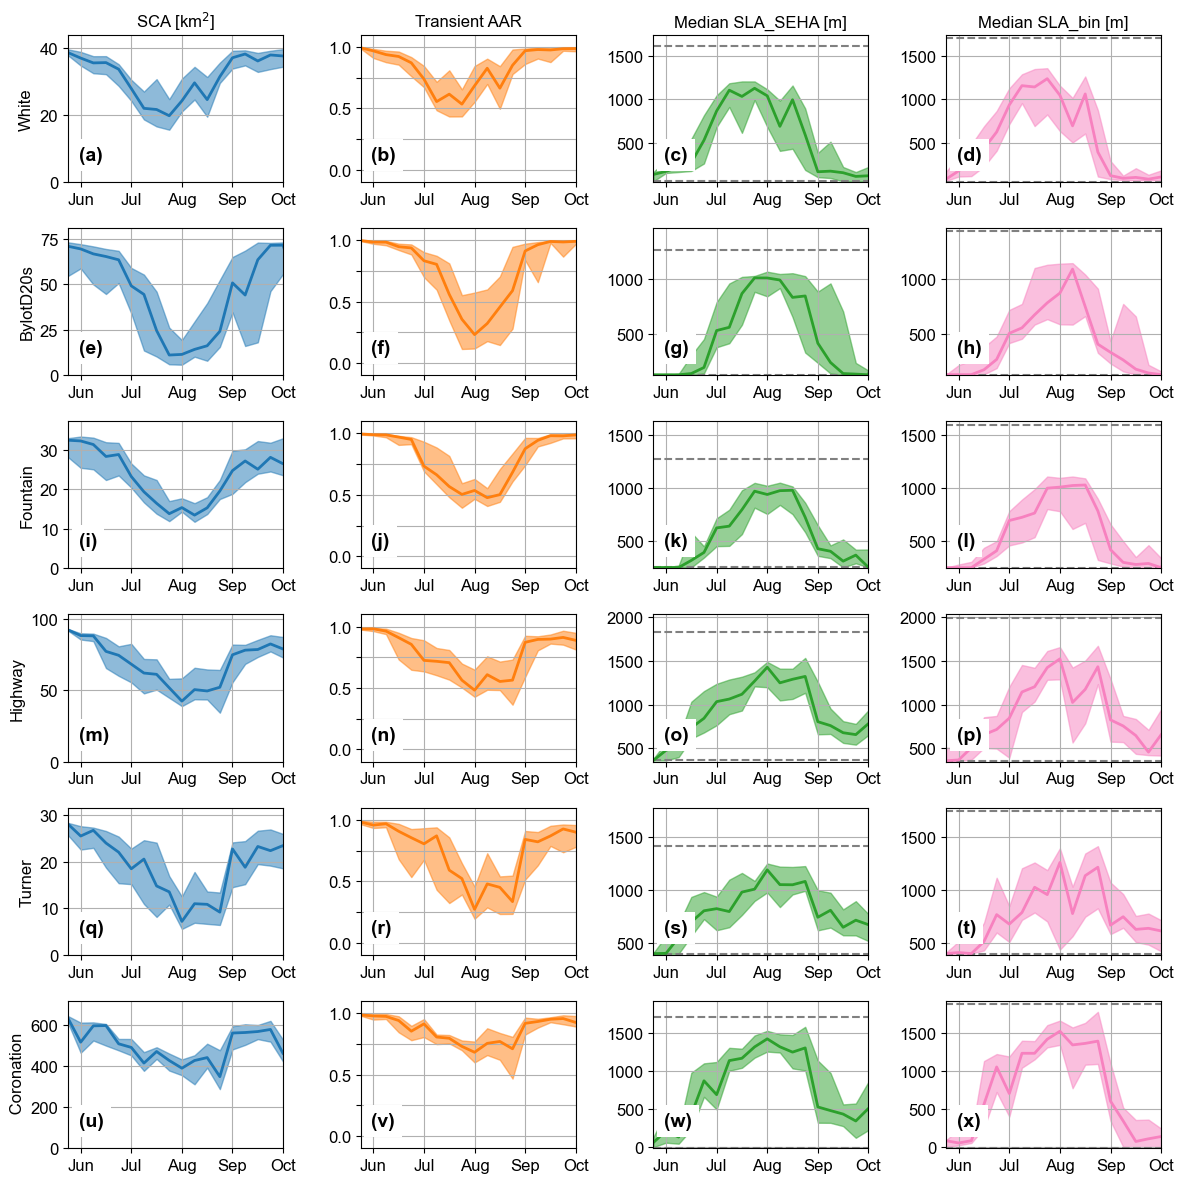

Figure 1 saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\figures\figS3_timeseries_SCA.png
Figure 2 saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\figures\fig05_weekly_median_trends_arranged.png


In [6]:
# -----Settings and display parameters
site_names = ['White', 'BylotD20s', 'Fountain', 'Highway', 'Turner', 'Coronation']
site_names_display = [x.replace('C', ' C') for x in site_names]
text_labels1 = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# -----Set up figures
fontsize = 12
plt.rcParams.update({'font.size': fontsize, 'font.sans-serif': 'Arial'})
# Fig1: Time series (SCA)
fig1, ax1 = plt.subplots(len(site_names), 1, figsize=(10, 2 * len(site_names)))
# Fig2: Weekly median trends with four panels (columns):
#  Column 0: SCA, Column 1: AAR, Column 2: Median snowline, Column 3: SLA (Binned)
fig2, ax2 = plt.subplots(len(site_names), 4, figsize=(12, 2 * len(site_names)))
alpha = 0.9

# Update text labels for Fig2 (4 labels per row; 6 rows now)
text_labels2 = [
    ['(a)', '(b)', '(c)', '(d)'],
    ['(e)', '(f)', '(g)', '(h)'],
    ['(i)', '(j)', '(k)', '(l)'],
    ['(m)', '(n)', '(o)', '(p)'],
    ['(q)', '(r)', '(s)', '(t)'],
    ['(u)', '(v)', '(w)', '(x)']
]

# -----Loop through sites
for site_name, site_name_display, text_label, i in zip(site_names, site_names_display, text_labels1, range(len(site_names))):
    
    print(site_name)
    
    # Subset and sort data for the current site
    sl_ests = sl_ests_full.loc[sl_ests_full['site_name'] == site_name].reset_index(drop=True)
    sl_ests = sl_ests.sort_values(by='datetime')
        
    # -----Define axis limits and y ranges
    xmin, xmax = np.datetime64('2013-05-01T00:00:00'), np.datetime64('2024-12-01T00:00:00')
    yrange1 = [0, np.nanmax(sl_ests['SCA_m2']) * 1e-6 * 1.1]
    yrange2_sca = yrange1
    yrange2_aar = [-0.1, 1.1]
    
    # For Median snowline altitude and SLA (Binned): 
    # Compute a common y-axis range based on both variables.
    sl_elev_median_min = np.nanmin(sl_ests['snowline_elevs_median_m'])
    sl_elev_median_max = np.nanmax(sl_ests['snowline_elevs_median_m'])
    min_sla_bin = np.nanmin(sl_ests['SLA_bin_method_m'])
    max_sla_bin = np.nanmax(sl_ests['SLA_bin_method_m'])
    common_y_min = min(sl_elev_median_min, min_sla_bin) * 0.97
    common_y_max = max(sl_elev_median_max, max_sla_bin) * 1.02
    yrange_common = [common_y_min, common_y_max]
    yrange2_snowline = yrange_common
    yrange2_sla_bin = yrange_common

    # -----Plot light grey boxes where no observations exist on SCA plots
    years = np.arange(2012, 2025, step=1)
    for year in years:
        min_date = np.datetime64(f'{year}-10-01')
        max_date = np.datetime64(f'{year+1}-05-01')
        rect = matplotlib.patches.Rectangle((min_date, yrange1[0]),
                                            width=max_date - min_date,
                                            height=yrange1[1]-yrange1[0],
                                            color='#d9d9d9')
        ax1[i].add_patch(rect)
        
    # -----Plot SCA time series 
    # Sentinel-2 (Surface Reflectance)
    ax1[i].plot(
        sl_ests['datetime'].loc[sl_ests['dataset'] == 'Sentinel-2_SR'], 
        np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset'] == 'Sentinel-2_SR'].values, 1e6),
        'D', markeredgecolor='w', markerfacecolor=color_Sentinel2_SR, 
        alpha=alpha, markersize=4, markeredgewidth=1,
        label='Sentinel-2 (Surface Reflectance)'
    )
    # Sentinel-2 (Top-of-Atmosphere)
    ax1[i].plot(
        sl_ests['datetime'].loc[sl_ests['dataset'] == 'Sentinel-2_TOA'], 
        np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset'] == 'Sentinel-2_TOA'].values, 1e6),
        'D', markeredgecolor=color_Sentinel2_TOA, markerfacecolor='None', 
        alpha=alpha, markersize=3, markeredgewidth=1.2,
        label='Sentinel-2 (Top-of-Atmosphere)'
    )  
    # Landsat
    ax1[i].plot(
        sl_ests['datetime'].loc[sl_ests['dataset'] == 'Landsat'], 
        np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset'] == 'Landsat'].values, 1e6),
        '^', markeredgecolor='w', markerfacecolor=color_Landsat, 
        alpha=alpha, markersize=6, markeredgewidth=1,
        label='Landsat'
    )       

    # -----Add glacier outline and horizontal reference lines:
    ax2[i,2].plot([15, 45], [sl_elev_median_min, sl_elev_median_min], '--', color='grey')  
    ax2[i,2].plot([15, 45], [sl_elev_median_max, sl_elev_median_max], '--', color='grey')  
    # For SLA (Binned): add horizontal lines for min and max
    ax2[i,3].plot([15, 45], [min_sla_bin, min_sla_bin], '--', color='grey')  
    ax2[i,3].plot([15, 45], [max_sla_bin, max_sla_bin], '--', color='grey')  
    
    # -----Adjust axes for Fig1
    ax1[i].set_xlim(xmin, xmax)
    ax1[i].set_ylim(yrange1[0], yrange1[1])
    ax1[i].set_xticks([np.datetime64(f'{year}-01-01') for year in np.arange(2013, 2026)])
    if site_name == site_names[-1]:
        ax1[i].set_xticklabels([str(year) for year in np.arange(2013, 2026)])
    else:
        ax1[i].set_xticklabels([])
    ax1[i].grid(True)
    ax1[i].text(np.datetime64('2013-05-01'),
                (ax1[i].get_ylim()[1] - ax1[i].get_ylim()[0]) * 0.06 + ax1[i].get_ylim()[0],
                f"{text_label} {site_names_display[i]} (N={len(sl_ests)})",
                bbox=dict(facecolor='white', edgecolor='black', pad=4),
                ha='left', va='bottom')
    
    if i == 2:
        ax1[i].set_ylabel('Snow-covered area [km$^2$]', fontsize=fontsize)
    ax2[i,0].set_ylabel(site_names_display[i], fontsize=fontsize)
        
    q1, q3 = 0.25, 0.75
    for ax, column, color, yrange, ylabel in zip(
        [ax2[i,0], ax2[i,1], ax2[i,2], ax2[i,3]],  # 4 panels
        ['SCA_m2', 'AAR', 'snowline_elevs_median_m', 'SLA_bin_method_m'], 
        [color_sca, color_aar, color_snowline, color_sla_bin],  
        [yrange2_sca, yrange2_aar, yrange2_snowline, yrange2_sla_bin],  
        ['SCA [km$^2$]', 'Transient AAR', 'Median SLA_SEHA [m]', 'Median SLA_bin [m]']
    ):
        weekly = sl_ests.groupby(by='Week')[column].agg([
            'median', lambda x: x.quantile(q1), lambda x: x.quantile(q3)
        ])
        weekly.columns = ['Median', 'Q1', 'Q3']
        weekly.index = weekly.index.astype(float)
        if column == 'SCA_m2':
            weekly = weekly / 1e6  # Convert from m^2 to km^2 for SCA
        ax.fill_between(weekly.index, weekly['Q1'], weekly['Q3'], color=color, alpha=0.5)
        ax.plot(weekly.index, weekly['Median'], color=color, linewidth=2)
        ax.grid(True)
        # Updated x-axis settings
        ax.set_xlim(22, 39)  # Span weeks covering June to September
        ax.set_xticks([23, 27, 31, 35, 39])  # Ticks for early June, July, August, September
        ax.set_xticklabels(['Jun', 'Jul', 'Aug', 'Sep','Oct'])  # Labels for each subplot
        ax.set_ylim(yrange[0], yrange[1])
        if column == 'AAR':
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
            ax.set_yticklabels(['0.0', '', '0.5', '', '1.0'])
        if i == 0:
            ax.set_title(ylabel, fontsize=fontsize)
    
    # -----Add text labels to each subplot in Fig2
    for j in range(4): 
        ax2[i, j].text(
            (ax2[i, j].get_xlim()[1] - ax2[i, j].get_xlim()[0]) * 0.05 + ax2[i, j].get_xlim()[0],
            (ax2[i, j].get_ylim()[1] - ax2[i, j].get_ylim()[0]) * 0.15 + ax2[i, j].get_ylim()[0],
            text_labels2[i][j], fontweight='bold', fontsize=fontsize+2,
            bbox=dict(facecolor='white', edgecolor='None', pad=5)
        )

# -----Add legend to Fig1
ax1[0].legend(loc='center', bbox_to_anchor=(0.5, 1.1), handletextpad=0.1,
              labelspacing=0.5, markerscale=2, ncol=4)

fig1.tight_layout()
fig2.tight_layout()
plt.show()

# -----Save figures if desired
if save_figures:
    fig1_fn = os.path.join(figures_out_path, 'figS3_timeseries_SCA.png')
    fig1.savefig(fig1_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('Figure 1 saved to file: ' + fig1_fn)
    fig2_fn = os.path.join(figures_out_path, 'fig05_weekly_median_trends_arranged.png')
    fig2.savefig(fig2_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('Figure 2 saved to file: ' + fig2_fn)


White
BylotD20s
Fountain
Highway
Turner
Coronation


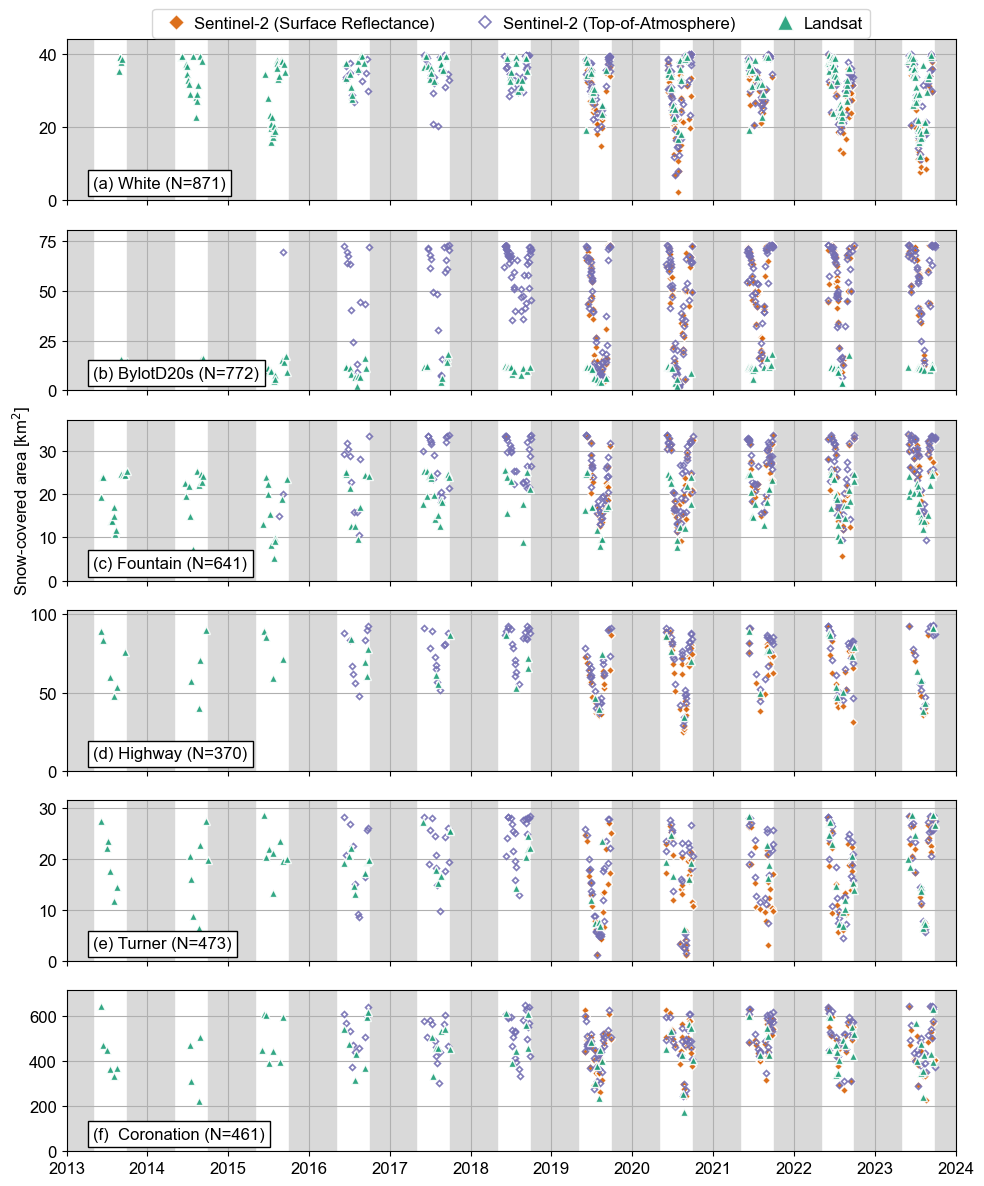

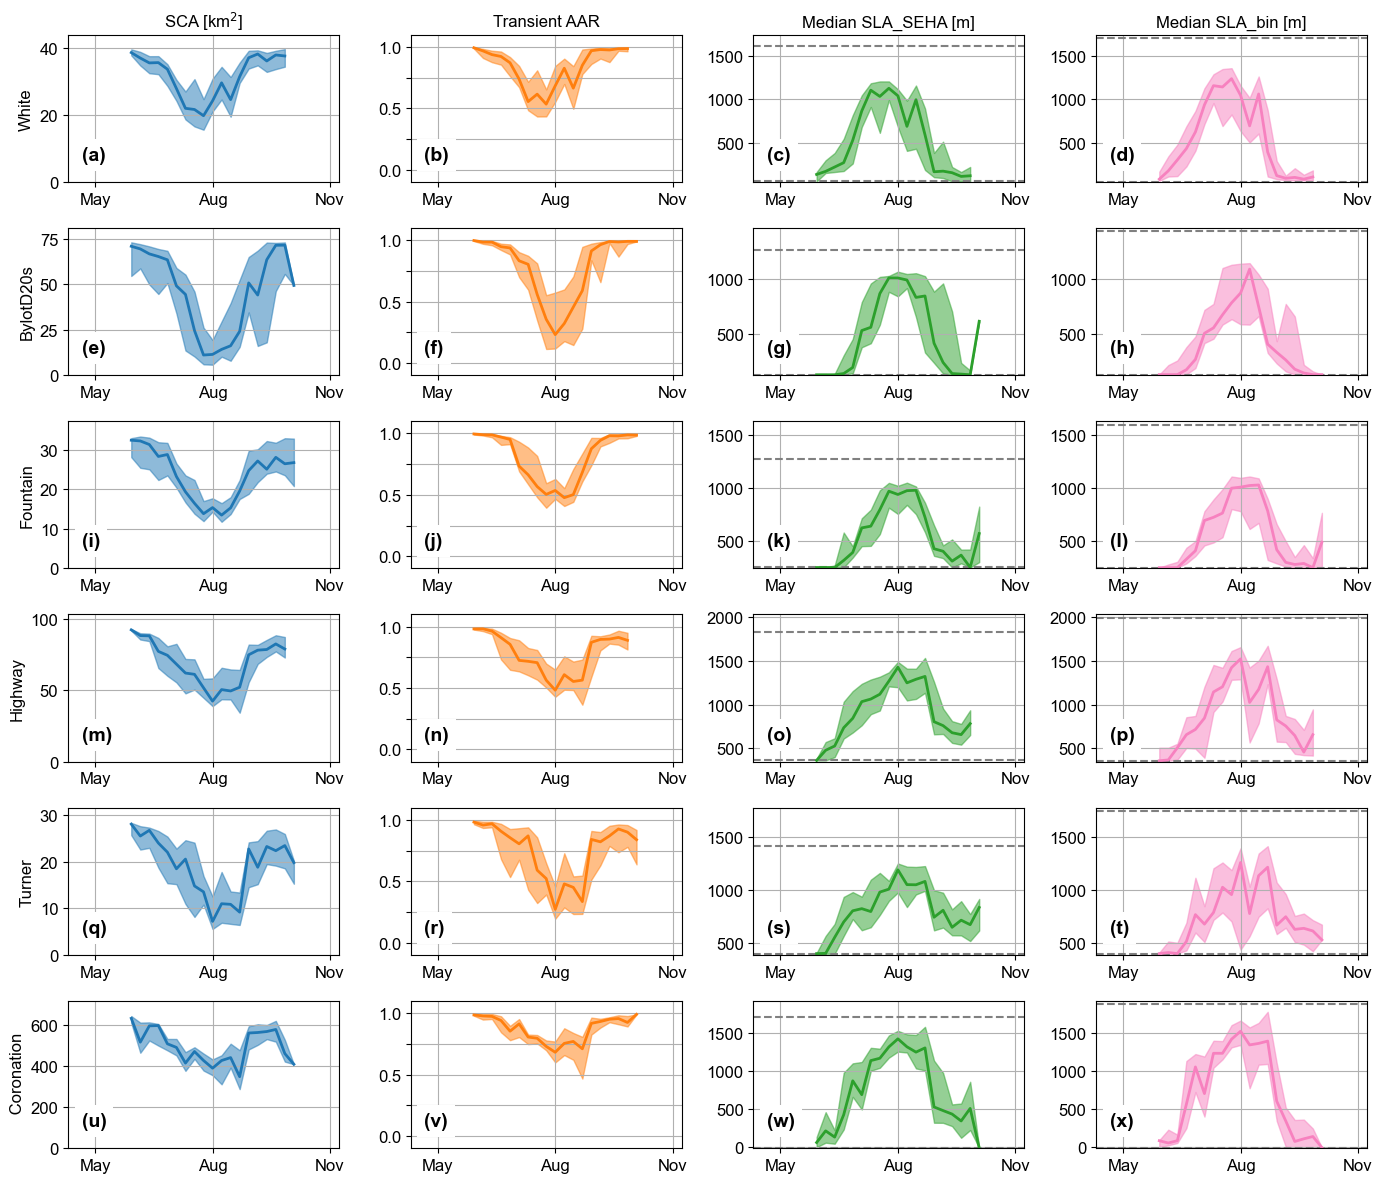

Figure 1 saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\figures\figS3_timeseries_SCA.png
Figure 2 saved to file: C:\Users\WilsonSIRL5-MCY-E113\Documents\glacier-snow-cover-mapping-for-ANP-and-SNP\figures\fig05_weekly_median_trends_arranged.png


In [7]:
# -----Settings and display parameters
site_names = ['White', 'BylotD20s', 'Fountain', 'Highway', 'Turner', 'Coronation']
site_names_display = [x.replace('C', ' C') for x in site_names]
text_labels1 = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# -----Set up figures
fontsize = 12
plt.rcParams.update({'font.size': fontsize, 'font.sans-serif': 'Arial'})
# Fig1: Time series (SCA)
fig1, ax1 = plt.subplots(len(site_names), 1, figsize=(10, 2 * len(site_names)))
# Fig2: Weekly median trends with four panels (columns):
#  Column 0: SCA, Column 1: AAR, Column 2: Median snowline, Column 3: SLA (Binned)
fig2, ax2 = plt.subplots(len(site_names), 4, figsize=(14, 2 * len(site_names)))
alpha = 0.9

# Update text labels for Fig2 (4 labels per row; 6 rows now)
text_labels2 = [
    ['(a)', '(b)', '(c)', '(d)'],
    ['(e)', '(f)', '(g)', '(h)'],
    ['(i)', '(j)', '(k)', '(l)'],
    ['(m)', '(n)', '(o)', '(p)'],
    ['(q)', '(r)', '(s)', '(t)'],
    ['(u)', '(v)', '(w)', '(x)']
]

# -----Loop through sites
for site_name, site_name_display, text_label, i in zip(site_names, site_names_display, text_labels1, range(len(site_names))):
    
    print(site_name)
    
    # Subset and sort data for the current site
    sl_ests = sl_ests_full.loc[sl_ests_full['site_name'] == site_name].reset_index(drop=True)
    sl_ests = sl_ests.sort_values(by='datetime')
        
    # -----Define axis limits and y ranges
    xmin, xmax = np.datetime64('2013-05-01T00:00:00'), np.datetime64('2023-12-01T00:00:00')
    yrange1 = [0, np.nanmax(sl_ests['SCA_m2']) * 1e-6 * 1.1]
    yrange2_sca = yrange1
    yrange2_aar = [-0.1, 1.1]
    
    # For Median snowline altitude and SLA (Binned): 
    # Compute a common y-axis range based on both variables.
    sl_elev_median_min = np.nanmin(sl_ests['snowline_elevs_median_m'])
    sl_elev_median_max = np.nanmax(sl_ests['snowline_elevs_median_m'])
    min_sla_bin = np.nanmin(sl_ests['SLA_bin_method_m'])
    max_sla_bin = np.nanmax(sl_ests['SLA_bin_method_m'])
    common_y_min = min(sl_elev_median_min, min_sla_bin) * 0.97
    common_y_max = max(sl_elev_median_max, max_sla_bin) * 1.02
    yrange_common = [common_y_min, common_y_max]
    yrange2_snowline = yrange_common
    yrange2_sla_bin = yrange_common

    # -----Plot light grey boxes where no observations exist on SCA plots
    years = np.arange(2012, 2025, step=1)
    for year in years:
        min_date = np.datetime64(f'{year}-10-01')
        max_date = np.datetime64(f'{year+1}-05-01')
        rect = matplotlib.patches.Rectangle((min_date, yrange1[0]),
                                            width=max_date - min_date,
                                            height=yrange1[1]-yrange1[0],
                                            color='#d9d9d9')
        ax1[i].add_patch(rect)
        
    # -----Plot SCA time series 
    # Sentinel-2 (Surface Reflectance)
    ax1[i].plot(
        sl_ests['datetime'].loc[sl_ests['dataset'] == 'Sentinel-2_SR'], 
        np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset'] == 'Sentinel-2_SR'].values, 1e6),
        'D', markeredgecolor='w', markerfacecolor=color_Sentinel2_SR, 
        alpha=alpha, markersize=4, markeredgewidth=1,
        label='Sentinel-2 (Surface Reflectance)'
    )
    # Sentinel-2 (Top-of-Atmosphere)
    ax1[i].plot(
        sl_ests['datetime'].loc[sl_ests['dataset'] == 'Sentinel-2_TOA'], 
        np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset'] == 'Sentinel-2_TOA'].values, 1e6),
        'D', markeredgecolor=color_Sentinel2_TOA, markerfacecolor='None', 
        alpha=alpha, markersize=3, markeredgewidth=1.2,
        label='Sentinel-2 (Top-of-Atmosphere)'
    )  
    # Landsat
    ax1[i].plot(
        sl_ests['datetime'].loc[sl_ests['dataset'] == 'Landsat'], 
        np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset'] == 'Landsat'].values, 1e6),
        '^', markeredgecolor='w', markerfacecolor=color_Landsat, 
        alpha=alpha, markersize=6, markeredgewidth=1,
        label='Landsat'
    )       

    # -----Add glacier outline and horizontal reference lines:
    ax2[i,2].plot([15, 45], [sl_elev_median_min, sl_elev_median_min], '--', color='grey')  
    ax2[i,2].plot([15, 45], [sl_elev_median_max, sl_elev_median_max], '--', color='grey')  
    # For SLA (Binned): add horizontal lines for min and max
    ax2[i,3].plot([15, 45], [min_sla_bin, min_sla_bin], '--', color='grey')  
    ax2[i,3].plot([15, 45], [max_sla_bin, max_sla_bin], '--', color='grey')  
    
    # -----Adjust axes for Fig1
    ax1[i].set_xlim(xmin, xmax)
    ax1[i].set_ylim(yrange1[0], yrange1[1])
    ax1[i].set_xticks([np.datetime64(f'{year}-01-01') for year in np.arange(2013, 2025)])
    if site_name == site_names[-1]:
        ax1[i].set_xticklabels([str(year) for year in np.arange(2013, 2025)])
    else:
        ax1[i].set_xticklabels([])
    ax1[i].grid(True)
    ax1[i].text(np.datetime64('2013-05-01'),
                (ax1[i].get_ylim()[1] - ax1[i].get_ylim()[0]) * 0.06 + ax1[i].get_ylim()[0],
                f"{text_label} {site_names_display[i]} (N={len(sl_ests)})",
                bbox=dict(facecolor='white', edgecolor='black', pad=4),
                ha='left', va='bottom')
    
    if i == 2:
        ax1[i].set_ylabel('Snow-covered area [km$^2$]', fontsize=fontsize)
    ax2[i,0].set_ylabel(site_names_display[i], fontsize=fontsize)
        
    q1, q3 = 0.25, 0.75
    for ax, column, color, yrange, ylabel in zip(
        [ax2[i,0], ax2[i,1], ax2[i,2], ax2[i,3]],  # 4 panels
        ['SCA_m2', 'AAR', 'snowline_elevs_median_m', 'SLA_bin_method_m'], 
        [color_sca, color_aar, color_snowline, color_sla_bin],  
        [yrange2_sca, yrange2_aar, yrange2_snowline, yrange2_sla_bin],  
        ['SCA [km$^2$]', 'Transient AAR', 'Median SLA_SEHA [m]', 'Median SLA_bin [m]']
    ):
        weekly = sl_ests.groupby(by='Week')[column].agg([
            'median', lambda x: x.quantile(q1), lambda x: x.quantile(q3)
        ])
        weekly.columns = ['Median', 'Q1', 'Q3']
        weekly.index = weekly.index.astype(float)
        if column == 'SCA_m2':
            weekly = weekly / 1e6  # Convert from m^2 to km^2 for SCA
        ax.fill_between(weekly.index, weekly['Q1'], weekly['Q3'], color=color, alpha=0.5)
        ax.plot(weekly.index, weekly['Median'], color=color, linewidth=2)
        ax.grid(True)
        ax.set_xlim(15, 45)
        ax.set_xticks([18, 31, 44])
        ax.set_xticklabels(['May', 'Aug', 'Nov'])
        ax.set_ylim(yrange[0], yrange[1])
        if column == 'AAR':
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
            ax.set_yticklabels(['0.0', '', '0.5', '', '1.0'])
        if i == 0:
            ax.set_title(ylabel, fontsize=fontsize)
    
    # -----Add text labels to each subplot in Fig2
    for j in range(4): 
        ax2[i, j].text(
            (ax2[i, j].get_xlim()[1] - ax2[i, j].get_xlim()[0]) * 0.05 + ax2[i, j].get_xlim()[0],
            (ax2[i, j].get_ylim()[1] - ax2[i, j].get_ylim()[0]) * 0.15 + ax2[i, j].get_ylim()[0],
            text_labels2[i][j], fontweight='bold', fontsize=fontsize+2,
            bbox=dict(facecolor='white', edgecolor='None', pad=5)
        )

# -----Add legend to Fig1
ax1[0].legend(loc='center', bbox_to_anchor=(0.5, 1.1), handletextpad=0.1,
              labelspacing=0.5, markerscale=2, ncol=4)

fig1.tight_layout()
fig2.tight_layout()
plt.show()

# -----Save figures if desired
if save_figures:
    fig1_fn = os.path.join(figures_out_path, 'figS3_timeseries_SCA.png')
    fig1.savefig(fig1_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('Figure 1 saved to file: ' + fig1_fn)
    fig2_fn = os.path.join(figures_out_path, 'fig05_weekly_median_trends_arranged.png')
    fig2.savefig(fig2_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('Figure 2 saved to file: ' + fig2_fn)


Processing White Glacier
Processing BylotD20s Glacier
Processing Fountain Glacier
Processing Highway Glacier
Processing Turner Glacier
Processing Coronation Glacier


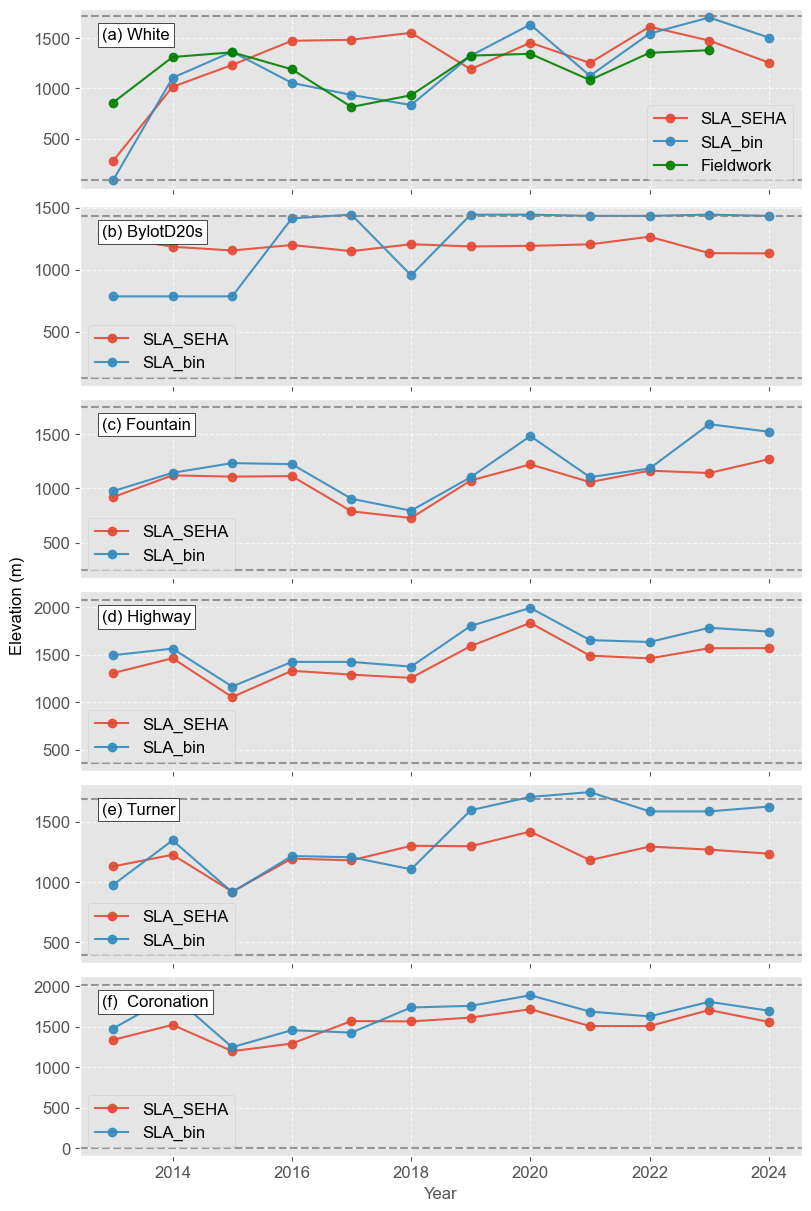

In [11]:
# -----Settings and display parameters
site_names = ['White', 'BylotD20s', 'Fountain', 'Highway', 'Turner', 'Coronation']
site_names_display = [x.replace('C', ' C') for x in site_names]
text_labels1 = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Hard-code the Zmin and Zmax values for each glacier
z_info = {
    'White':       {'Zmin': 85.75,   'Zmax': 1722.19},
    'BylotD20s':   {'Zmin': 128.67,  'Zmax': 1433.26},
    'Fountain':    {'Zmin': 244.95,  'Zmax': 1752.85},
    'Highway':     {'Zmin': 362.62,  'Zmax': 2082.26},
    'Turner':      {'Zmin': 393.98,  'Zmax': 1684.84},
    'Coronation':  {'Zmin': 8.00,    'Zmax': 2017.22}
}

# -----Fieldwork data for White Glacier
fieldwork_data = {
    'Year': [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Fieldwork': [858, 1312, 1359, 1190, 816, 932, 1326, 1344, 1083, 1354, 1380]
}
df_fieldwork = pd.DataFrame(fieldwork_data)

# -----Set up figure with adjusted sizes and spacing
fontsize = 12
plt.rcParams.update({
    'font.size': fontsize,
    'font.sans-serif': 'Arial',
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize
})

fig1, ax1 = plt.subplots(6, 1, figsize=(8, 12), constrained_layout=True)
alpha = 0.9

# -----Loop through each glacier site
for site_name, site_name_display, text_label, i in zip(site_names, site_names_display, text_labels1, range(len(site_names))):
    sl_est_path = os.path.join(study_sites_path, site_name)
    sl_est_fns = glob.glob(os.path.join(sl_est_path, '*_annual.csv'))
    print(f"Processing {site_name} Glacier")

    # Find matching CSV files for the current glacier (case-insensitive)
    matching_files = [fn for fn in sl_est_fns if site_name.lower() in os.path.basename(fn).lower()]
    
    if matching_files:
        # Read the first matching CSV file for this glacier
        df = pd.read_csv(matching_files[0])
        
        # Ensure there's a 'year' column; if not, use the index
        if 'year' not in df.columns:
            df['year'] = df.index
        
        # Plot annual ELA and SLA
        ax1[i].plot(df['year'], df['ELA_m'], 'o-', label='SLA_SEHA', alpha=alpha, linewidth=1.5)
        ax1[i].plot(df['year'], df['SLA_m'], 'o-', label='SLA_bin', alpha=alpha, linewidth=1.5)



        # Add Fieldwork data for White Glacier only
        if site_name == 'White':
            ax1[i].plot(df_fieldwork['Year'], df_fieldwork['Fieldwork'],
                        label='Fieldwork', marker='o', alpha=alpha, color='green')
        
        # Only set x-axis label for bottom subplot
        if i == len(site_names) - 1:
            ax1[i].set_xlabel('Year')
        else:
            ax1[i].set_xlabel('')
            ax1[i].set_xticklabels([])

        # Remove individual y-axis labels
        ax1[i].set_ylabel('')  

        # Position the text annotation
        x_min, x_max = ax1[i].get_xlim()
        y_min, y_max = ax1[i].get_ylim()
        x_pos = x_min + 0.05 * (x_max - x_min)  # Move 5% from the left
        y_pos = y_max - 0.05 * (y_max - y_min)  # Move 5% down from the top

        # Annotate the glacier name
        ax1[i].text(
            0.03, 0.90,  # x=3% from left, y=93% from bottom
            f"{text_label} {site_name_display}",
            transform=ax1[i].transAxes,  # use Axes coordinates
            bbox=dict(facecolor='white', edgecolor='black', pad=3),
            verticalalignment='top',
            horizontalalignment='left'
        )

        # Draw horizontal lines for Zmin and Zmax
        # (adjust color, linestyle, alpha as you like)
        zmin = z_info[site_name]['Zmin']
        zmax = z_info[site_name]['Zmax']

        ax1[i].axhline(y=zmin, color='grey', linestyle='--', alpha=0.8)
        ax1[i].axhline(y=zmax, color='grey', linestyle='--', alpha=0.8)

        ax1[i].grid(True, linestyle='--', alpha=0.7)
        ax1[i].legend(loc='best')

# Add a single "Elevation (m)" label on the left side of all subplots
fig1.supylabel('Elevation (m)', fontsize=fontsize)
plt.show()

['C:\\Users\\WilsonSIRL5-MCY-E113\\Documents\\glacier-snow-cover-mapping-for-ANP-and-SNP\\study-sites\\Coronation\\snow_cover_stats20130606_20240924_Coronation_annual.csv']
Processing White Glacier
['C:\\Users\\WilsonSIRL5-MCY-E113\\Documents\\glacier-snow-cover-mapping-for-ANP-and-SNP\\study-sites\\White\\snow_cover_stats20130823_20240929_white_annual.csv']
Processing BylotD20s Glacier
['C:\\Users\\WilsonSIRL5-MCY-E113\\Documents\\glacier-snow-cover-mapping-for-ANP-and-SNP\\study-sites\\BylotD20s\\snow_cover_stats20130608_20240927_BylotD20s_annual.csv']
Processing Fountain Glacier
['C:\\Users\\WilsonSIRL5-MCY-E113\\Documents\\glacier-snow-cover-mapping-for-ANP-and-SNP\\study-sites\\Fountain\\snow_cover_stats20130606_20240927_Fountain_annual.csv']
Processing Highway Glacier
['C:\\Users\\WilsonSIRL5-MCY-E113\\Documents\\glacier-snow-cover-mapping-for-ANP-and-SNP\\study-sites\\Highway\\snow_cover_stats20130606_20240925_Highway_annual.csv']
Processing Turner Glacier
['C:\\Users\\WilsonSIR

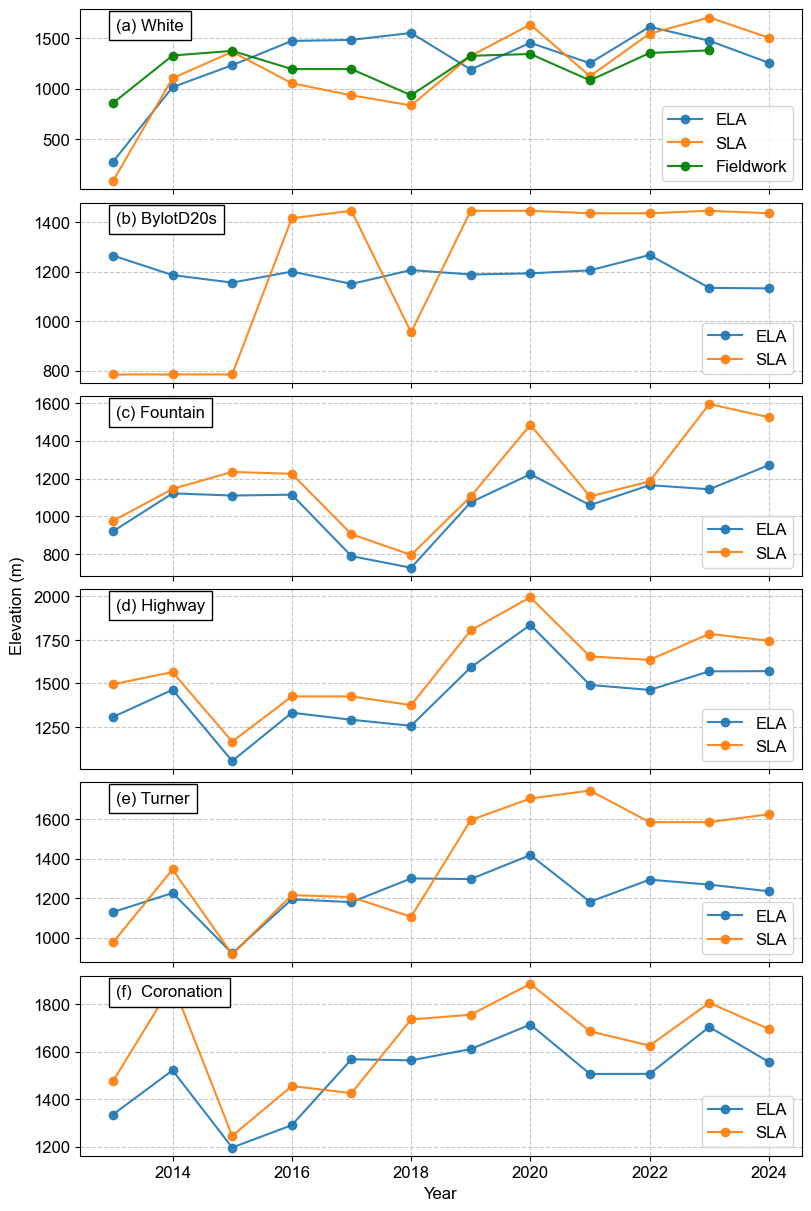

In [9]:
# -----Settings and display parameters
site_names = ['White', 'BylotD20s', 'Fountain', 'Highway', 'Turner', 'Coronation']
site_names_display = [x.replace('C', ' C') for x in site_names]
text_labels1 = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# -----Fieldwork data for White Glacier
fieldwork_data = {
    'Year': [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    'Fieldwork': [858, 1329, 1375, 1195, 1195, 936, 1326, 1344, 1083, 1354, 1380]
}
df_fieldwork = pd.DataFrame(fieldwork_data)

# -----Set up figure with adjusted sizes and spacing
fontsize = 12
plt.rcParams.update({
    'font.size': fontsize,
    'font.sans-serif': 'Arial',
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize
})
# Fig1: Time series (SCA) with adjusted height for better spacing (5 rows, 1 column)
fig1, ax1 = plt.subplots(6, 1, figsize=(8, 12), constrained_layout=True)
alpha = 0.9

# -----Loop through each glacier site
for site_name, site_name_display, text_label, i in zip(site_names, site_names_display, text_labels1, range(len(site_names))):
    print(sl_est_fns)
    sl_est_path = os.path.join(study_sites_path, site_name)
    sl_est_fns = glob.glob(os.path.join(sl_est_path, '*_annual.csv'))
    print(f"Processing {site_name} Glacier")
    
    # Find matching CSV files for the current glacier (case insensitive)
    matching_files = [fn for fn in sl_est_fns if site_name.lower() in os.path.basename(fn).lower()]
    
    if matching_files:
        # Read the first matching CSV file for this glacier
        df = pd.read_csv(matching_files[0])
        
        # Ensure there's a 'Year' column; if not, use the index
        if 'year' not in df.columns:
            df['year'] = df.index
        
        # Plot annual ELA and SLA for this glacier on its respective subplot
        ax1[i].plot(df['year'], df['ELA_m'], label='ELA', marker='o', alpha=alpha)
        ax1[i].plot(df['year'], df['SLA_m'], label='SLA', marker='o', alpha=alpha)

        # Add Fieldwork data for White Glacier only (i == 0)
        if site_name == 'White':
            ax1[i].plot(df_fieldwork['Year'], df_fieldwork['Fieldwork'], label='Fieldwork', marker='o', alpha=alpha, color='green')
        
        # Only set x-axis label for bottom subplot
        if i == len(site_names) - 1:
            ax1[i].set_xlabel('Year')
        else:
            ax1[i].set_xlabel('')  
            ax1[i].set_xticklabels([])  

        # Remove individual y-axis labels for "Elevation (m)"
        ax1[i].set_ylabel('')  # Clear all y-labels for now

        # Add study site name as text annotation, moved more inside the plot
        # Adjust the x and y coordinates to position the text inside the plot
        x_min, x_max = ax1[i].get_xlim()
        y_min, y_max = ax1[i].get_ylim()
        x_pos = x_min + 0.05 * (x_max - x_min)  # Move 5% from the left edge
        y_pos = y_max - 0.05 * (y_max - y_min)  # Move 5% down from the top edge
        ax1[i].text(
            x_pos,  # Adjusted X-coordinate
            y_pos,  # Adjusted Y-coordinate
            f"{text_label} {site_name_display}",  # Text string to display
            bbox=dict(facecolor='white', edgecolor='black', pad=5),
            verticalalignment='top',  # Align text to the top
            horizontalalignment='left'  # Align text to the left
        )
        
        ax1[i].grid(True, linestyle='--', alpha=0.7)
        ax1[i].legend(loc='lower right')

# Add a single "Elevation (m)" label in the middle of the master plot
# Use the figure's supylabel to place the label on the left side of all subplots
fig1.supylabel('Elevation (m)', fontsize=fontsize)

plt.show()

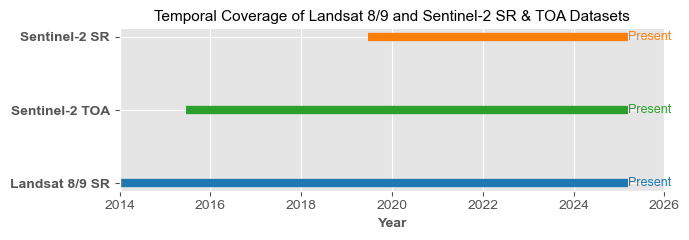

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Define the temporal coverage of each dataset
datasets = {
    'Landsat 8/9 SR': {'start': datetime(2013, 4, 1), 'end': datetime(2025, 3, 14)},
    'Sentinel-2 TOA': {'start': datetime(2015, 6, 23), 'end': datetime(2025, 3, 14)},
    'Sentinel-2 SR': {'start': datetime(2019, 6, 23), 'end': datetime(2025, 3, 14)}
}

# Use a clean style for a professional appearance
plt.style.use('ggplot')

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 2.5))

# Define colors for each dataset
colors = ['tab:blue', 'tab:green', 'tab:orange']

# Plot each dataset's temporal coverage as a horizontal line
for i, (dataset, period) in enumerate(datasets.items()):
    start, end = period['start'], period['end']
    ax.hlines(y=i, xmin=start, xmax=end, linewidth=6, color=colors[i])  # Thicker bars
    ax.text(end, i, 'Present', ha='left', va='center', fontsize=9, color=colors[i])

# Customize y-axis with dataset labels
ax.set_yticks(range(len(datasets)))
ax.set_yticklabels(datasets.keys(), fontsize=10, fontweight='bold') 

# Format the x-axis as dates
ax.set_xlabel('Year', fontsize=10, fontweight='bold')
ax.set_xlim(datetime(2014, 1, 1), datetime(2026, 1, 1))
ax.xaxis.set_major_locator(mdates.YearLocator(2))  # Show ticks every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(axis='x', labelsize=10)

# Add title
ax.set_title('Temporal Coverage of Landsat 8/9 and Sentinel-2 SR & TOA Datasets', fontsize=11)

# Remove unnecessary spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout for a compact, professional appearance
plt.tight_layout()

# Show the plot
plt.show()
